# 第十八、十九、二十次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW18-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">6月10日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
torch.manual_seed(0)
np.random.seed(0)

### 读取数据并划分数据集（勿更改代码）

In [2]:

def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

# 一、隐马尔可夫模型（2分）

### 1.1 准备数据（0.5分）

In [3]:
from hmmlearn import hmm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [4]:
def extract_features(data):
    # TODO: 0.5分
    X_features = []
    X_lengths = []
    for sequence in data:
        features = [ord(char) for char in sequence]  # Convert each character to its ASCII value
        X_features.extend(features)
        X_lengths.append(len(features))
    return np.array(X_features).reshape(-1, 1), X_lengths

X_train_features, X_train_lengths = extract_features(X_train)
X_test_features, X_test_lengths = extract_features(X_test)

### 1.2 使用HMM模型进行训练、预测（1分）

In [5]:
# 训练HMM模型
hmm_model = hmm.MultinomialHMM(n_components=n_tags, n_iter=100)
hmm_model.fit(X_train_features, X_train_lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=13, n_iter=100,
               n_trials=array([109,  97, 108, ..., 101,  99, 101]),
               random_state=RandomState(MT19937) at 0x2117B17B440)

In [6]:
# HMM预测
def hmm_predict(model, X, lengths):
    # TODO: 1分
    start = 0
    y_pred = []
    for length in lengths:
        end = start + length
        sequence = X[start:end]
        logprob, state_sequence = model.decode(sequence, algorithm="viterbi")
        y_pred.append(state_sequence[0])  # Using the state of the first observation as prediction
        start = end
    return np.array(y_pred)


y_train_pred = hmm_predict(hmm_model, X_train_features, X_train_lengths)
y_test_pred = hmm_predict(hmm_model, X_test_features, X_test_lengths)


### 1.3 模型评估（0.5分）

In [7]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct / len(y_true)


# HMM结果
print("HMM结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

HMM结果
train set accuracy: 0.0413
test set accuracy: 0.0413


## 二、RNN模型的应用（3分）

### 2.1 数据准备和预处理（0.5分）

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [8]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [9]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [10]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [11]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    # TODO: 0.5分
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))
    return to_ret

### 2.2 RNN网络的搭建（1分）

In [12]:
class RNN_net(nn.Module):
    # TODO: 1分
    def __init__(self, embedding_dim, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size) 

### 2.3 模型的训练（1分）

In [13]:
# function to train the data

def train_step(net, opt, criterion, batch_size):
    
    # TODO: 0.5分      
           
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step() 
         
    return total_loss/batch_size

In [14]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):


    # TODO: 0.5分
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    loss_arr = np.zeros(steps)
    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")

Iteration number: 5 Loss: 2.5367
Iteration number: 10 Loss: 2.4825
Iteration number: 15 Loss: 2.3876
Iteration number: 20 Loss: 2.2298
Iteration number: 25 Loss: 2.1833
Iteration number: 30 Loss: 2.1372
Iteration number: 35 Loss: 2.0233
Iteration number: 40 Loss: 2.0973
Iteration number: 45 Loss: 2.0237
Iteration number: 50 Loss: 2.0742
Iteration number: 55 Loss: 2.0788
Iteration number: 60 Loss: 2.0106
Iteration number: 65 Loss: 1.9811
Iteration number: 70 Loss: 1.974
Iteration number: 75 Loss: 1.9743
Iteration number: 80 Loss: 1.8843
Iteration number: 85 Loss: 1.8065
Iteration number: 90 Loss: 1.8837
Iteration number: 95 Loss: 1.8556
Iteration number: 100 Loss: 1.8595


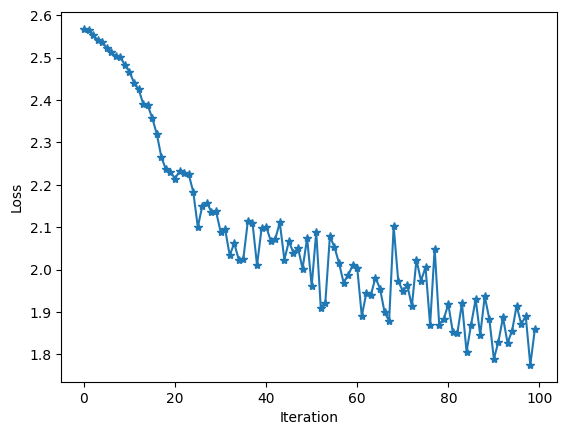

In [15]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)

### 2.4 模型的评估（0.5分）

In [16]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [17]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [18]:
#create a function to evaluate model

def eval_train(net):
     # TODO: 0.5分
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)
     return accuracy

In [19]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.3936
test set accuracy:0.3927


## 三、预训练模型的使用（3分）

### 3.1 数据准备和预处理，模型的导入（0.5分）

In [20]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained("D:\model")
bert_model = BertModel.from_pretrained("D:\model")

### 3.2 使用BERT进行特征提取（1分）

In [21]:
# 提取BERT特征
def extract_bert_features(data):

    # TODO: 1分
    inputs = tokenizer(data, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token representation as the feature
    features = outputs.last_hidden_state[:, 0, :].numpy()
    return features

# 提取训练集和测试集的特征
X_train_features = extract_bert_features(X_train)
X_test_features = extract_bert_features(X_test)

In [22]:
# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 3.3 使用一个分类器对提取好的特征进行分类（1分）

In [23]:
# TODO: 1分
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train_encoded)

c:\Users\iculi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [24]:
# 预测
y_train_pred = clf.predict(X_train_features)
y_test_pred = clf.predict(X_test_features)

### 3.4 评估结果（0.5分）

In [25]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)

# BERT结果
print("BERT结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

BERT结果
train set accuracy: 0.602
test set accuracy: 0.4149


## 四、三种模型的总结与分析（1分）

请简述这次作业使用的数据集在三种模型下的表现产生显著差异的原因，并且给出能够提高HMM表现的数据加强方式。


### 模型表现差异的原因

#### 1. 隐马尔可夫模型（HMM）

- **特征依赖性**：HMM依赖于词和词性之间的简单概率关系，假设词序列是通过马尔可夫过程生成的。它适用于序列长度较短或特征简单的任务。
- **局限性**：HMM的参数是通过统计数据进行估计的，对于复杂的语言现象（如长距离依赖关系和多义词）处理能力有限。
- **维度诅咒**：随着序列长度的增加，状态数目呈指数增长，导致模型复杂度急剧增加。

#### 2. 循环神经网络（RNN）

- **特征捕捉**：RNN通过隐状态（hidden state）捕捉词序列中的长短期依赖关系，因此能够比HMM更好地处理上下文信息。
- **长距离依赖问题**：标准的RNN在处理长距离依赖时存在梯度消失和梯度爆炸问题，这限制了其在长序列上的表现。
- **改进变体**：长短期记忆网络（LSTM）和门控循环单元（GRU）等变体通过引入门机制部分解决了长距离依赖问题。

#### 3. BERT（基于Transformer架构）

- **双向注意力机制**：BERT采用自注意力机制，可以同时考虑序列中所有词之间的依赖关系，因此能够更好地捕捉长距离依赖和复杂的上下文关系。
- **预训练和微调**：BERT首先在大规模语料库上进行无监督预训练，然后在特定任务上进行微调，显著提高了模型的泛化能力和表现。
- **计算成本**：BERT的多层Transformer架构虽然强大，但也带来了高计算和存储成本。

### 提高HMM表现的数据增强方式

为了提高HMM在特定任务中的表现，可以采用以下数据增强方式：

#### 1. 增加数据量

- **扩展词典和语料库**：收集更多的文本数据，扩展词典，提高模型的训练数据量，有助于更好地估计转移概率和发射概率。

#### 2. 增强数据质量

- **数据清洗和预处理**：去除噪声数据，标准化文本格式，提高数据质量，使模型能够更准确地学习词性和词之间的关系。

#### 3. 特征工程

- **引入更多上下文特征**：不仅仅依赖于当前词和前一个词的关系，可以考虑引入前后n个词的上下文信息作为特征。
- **添加外部词性词典**：结合外部词性标注词典，提高模型的初始参数估计精度。

#### 4. 半监督学习

- **伪标签生成**：利用部分标注数据训练初步模型，然后用该模型为未标注数据生成伪标签，扩充训练数据集。

#### 5. 混合模型

- **结合其他模型的输出**：利用RNN或BERT的预测结果作为HMM的输入特征，结合多种模型的优势，提高HMM的表现。


## 附加题：期末笔试题目的参考

### 附加题 马尔可夫模型的原理理解（1分）

(1) 阅读以下题目，补全solve函数，并且将结果提交到codeforces平台上，将代码运行结果截图（包含用户名、AC的结果、运行时间等信息）（0.5分）

提交的网址：https://codeforces.com/problemset/problem/1025/G

运行结果截图

<img src = '31.png' >

In [26]:
n=int(input())
lis=input().split()

siz = [0] * (n+1)
for i in range(n):
    lis[i] = int(lis[i])
    if lis[i] > 0:
        siz[lis[i]] += 1
r = 0
for i in range(n+1):
    r += 2**siz[i] - 1

r = 2**(n-1) - 1 - r
print(int(r % (10**9 + 7)))

IndentationError: expected an indented block (934356517.py, line 4)

(2) 对以上代码的正确性给出证明（0.5分）

- 设收购了n家公司的活跃公司势能函数为$f(n)$
- 公司索引为$i$
- 总势能函数为$g(t)=\sum_i f(n)$
为保证$E[g(t+1)|某一局面]=E[g(t)|某一局面]+1$,对$\forall x,y$,有:
$$f(x)+f(y)+1=\frac{1}{2}(xf(0)+f(y+1))+\frac{1}{2}(f(x+1)+yf(0))$$

令$y=x$,得到
$$2f(x)+1=xf(0)+f(x+1)$$
解得$$f(x)=2^x-1+(x+1)f(0)$$
验证发现符合条件.此时,
$$E(t|局面为最终局面)=T\Rightarrow=E[g(T)]=(n-1)f(0)+f(n-1)=T+E[g(0)]$$
$$\Rightarrow T=2^n+n-1-\sum 2^{siz[i]},其中siz[i]是初始时第i家公司收购的公司数量$$
